*First compiled on May 5th, 2017.*

### Scanpy analysis of 3k PBMC following a Seurat Tutorial

Scanpy allows to reproduce Seurat's standard workflow as described on http://satijalab.org/seurat/pbmc-tutorial.html (March 30, 2017). Many thanks to the Seurat authors for this beautiful tutorial!

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x ([here](https://support.10xgenomics.com/single-cell/datasets/pbmc3k), section *Chromium Demonstration (v1 Chemistry)* in [datasets](https://support.10xgenomics.com/single-cell/datasets)).

In [1]:
%config InlineBackend.figure_formats = ['png2x']  # for vector graphics quality, set 'svg'
import numpy as np
import scanpy.api as sc

sc.settings.verbosity = 3                # show some output
sc.settings.set_dpi(70)                  # dots (pixels) per inch determine size of inline figures
sc.logging.print_version_and_date()

Running Scanpy version 0.2 on 2017-07-24 00:29.


Load the data into an `AnnData` object `adata` which consists of the data matrix `adata.X`, sample/cell annotation `adata.smp` and variable/gene annotation `adata.var` and additional unstructured annotation `adata.add`.

For a large file, this takes a longer time only when first reading the `.mtx` text file.

Read the gene/variable and sample names using a standard numpy function.

In [2]:
filename_data = './data/pbmc3k_filtered_gene_bc_matrices/hg19/matrix.mtx'
filename_genes = './data/pbmc3k_filtered_gene_bc_matrices/hg19/genes.tsv'
filename_barcodes = './data/pbmc3k_filtered_gene_bc_matrices/hg19/barcodes.tsv'
adata = sc.read(filename_data, cache=True).transpose()
adata.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
adata.smp_names = np.genfromtxt(filename_barcodes, dtype=str)

reading file ./write/data/pbmc3k_filtered_gene_bc_matrices/hg19/matrix.h5


Basic filtering.

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

... filtered out 0 cells that have less than 200 genes expressed
... filtered out 19024 genes that are detected in less than 3 cells


Plot some information about mitochondrial genes, important for quality control

In [4]:
mito_genes = np.array([name for name in adata.var_names if name.startswith('MT-')])
# for each cell compute fraction of counts in mito genes vs. all genes
adata.smp['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as sample annotation to adata
adata.smp['n_counts'] = np.sum(adata.X, axis=1).A1

A violin plot of the computed quality measures.

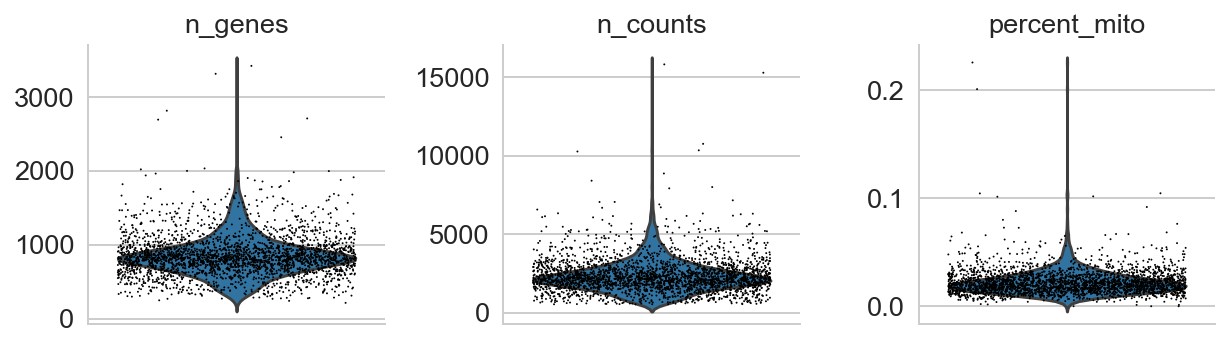

In [5]:
axs = sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                   jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

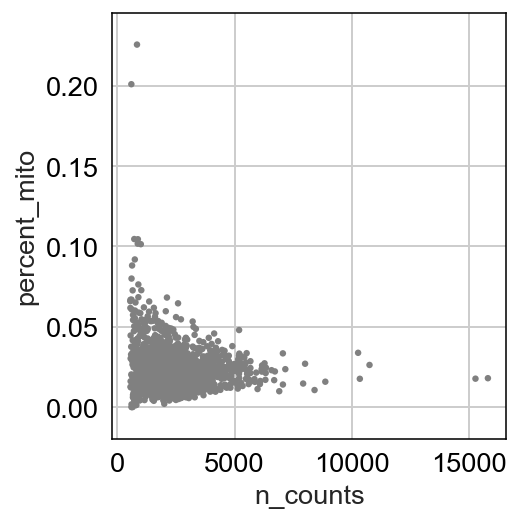

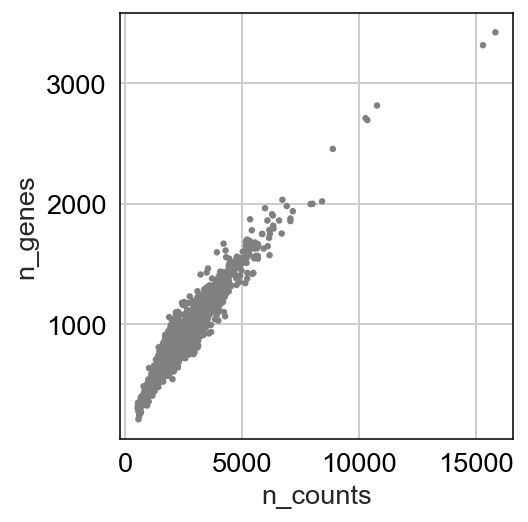

In [6]:
axs = sc.pl.scatter(adata, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(adata, x='n_counts', y='n_genes')

Actually do the filtering.

In [7]:
adata = adata[adata.smp['n_genes'] < 2500, :]
adata = adata[adata.smp['percent_mito'] < 0.05, :]

Save the logarithmized raw gene expression for later use in differential testing.

In [8]:
sc.write('pbmc3k_filtered_raw_log', sc.pp.log1p(adata, copy=True))

writing ./write/pbmc3k_filtered_raw_log.h5


Per-cell normalize the data matrix $X$, identify highly-variable genes and compute logarithm.

... normalizing by total count per cell
... filtered out 0 cells that have less than 1 counts
    finished, (0:00:00.050)     normalized adata.X and added
    "n_counts", counts per cell before normalization (adata.smp)
... filter highly varying genes by dispersion and mean (0:00:00.086)
    using `min_disp=0.5`, `max_disp=None`, `min_mean=0.0125` and `max_mean=3`
--> set `n_top_genes` to simply select top-scoring genes instead


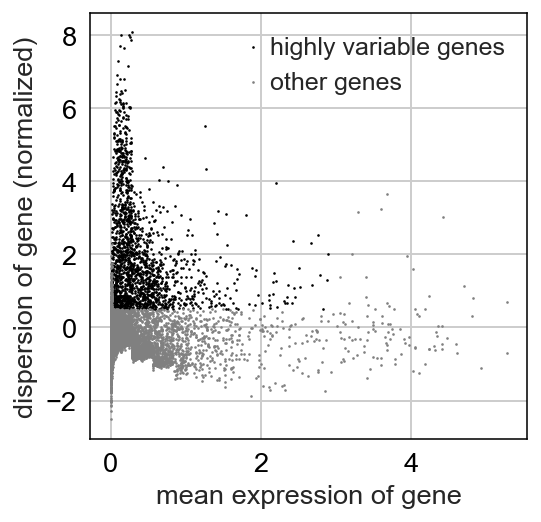

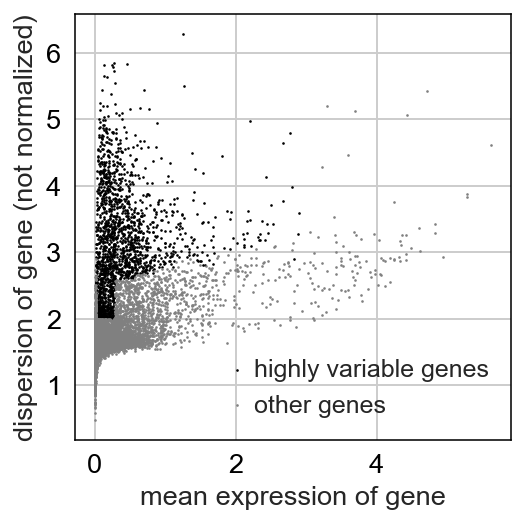

In [9]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

Actually do the filtering and logarithmize the data.

In [10]:
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [11]:
adata_corrected = sc.pp.regress_out(adata, ['n_counts', 'percent_mito'],
                                    copy=True)

regressing out ['n_counts', 'percent_mito']
... sparse input is densified and may lead to huge memory consumption

finished (0:00:10.277)
--> after `sc.pp.regress_out`, consider rescaling the adata using `sc.pp.scale`


In [12]:
sc.pp.scale(adata_corrected, max_value=10)

... clipping at max_value 10


### PCA

Compute PCA and make a scatter plot.

compute PCA with n_comps = 50
    finished (0:00:01.128) and added
    "X_pca", the PCA coordinates (adata.smp)
    "PC1", "PC2", ..., the loadings (adata.var)
    "pca_variance_ratio", the variance ratio (adata.add)


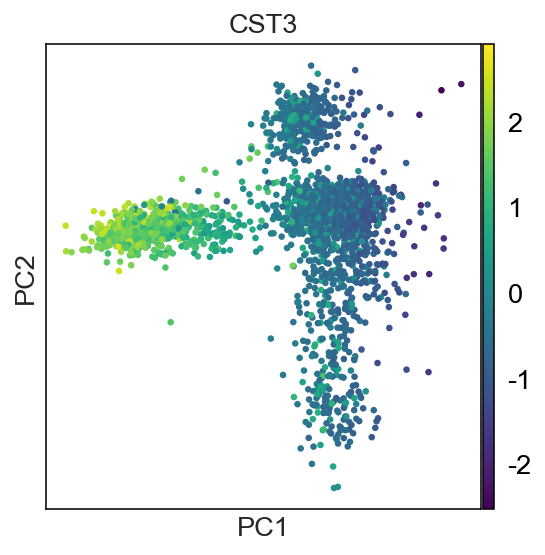

In [13]:
sc.tl.pca(adata_corrected)
adata_corrected.smp['X_pca'] *= -1  # multiply by 1 to match Seurat R
ax = sc.pl.pca_scatter(adata_corrected, color='CST3', right_margin=0.2)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

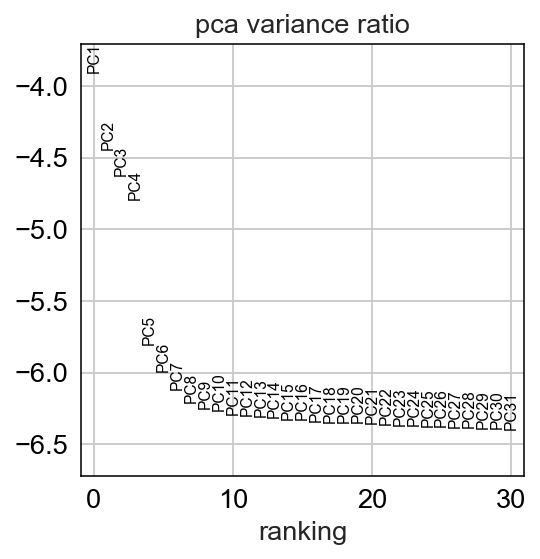

In [14]:
sc.pl.pca_variance_ratio(adata_corrected, log=True)

### tSNE

In [15]:
sc.tl.tsne(adata_corrected, n_pcs=10)

compute tSNE
    using X_pca for tSNE
    using 10 principal components
    using package MulticoreTSNE
    finished (0:00:08.933) and added
    "X_tsne", tSNE coordinates (adata.smp)


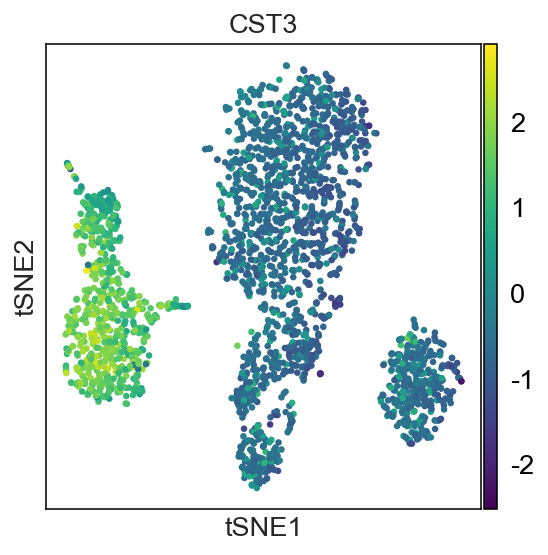

In [16]:
ax = sc.pl.tsne(adata_corrected, color='CST3')

### Clustering

As Seurat and many others, we use the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine *et al.* (2015)](https://doi.org/10.1016/j.cell.2015.05.04).

In [17]:
sc.tl.louvain(adata_corrected, n_neighbors=10, resolution=1.3, recompute_graph=True)

run Louvain clustering
initializing data graph with `n_neighbors=10`
    using X_pca for building graph
    finished (0:00:01.348) and found 8 clusters, added
    "louvain_groups", the cluster labels (adata.smp)
    "louvain_groups_names", the unique cluster labels (adata.add)


Plot the data with tSNE. Coloring according to clustering. Clusters agree quite well with the result of Seurat.

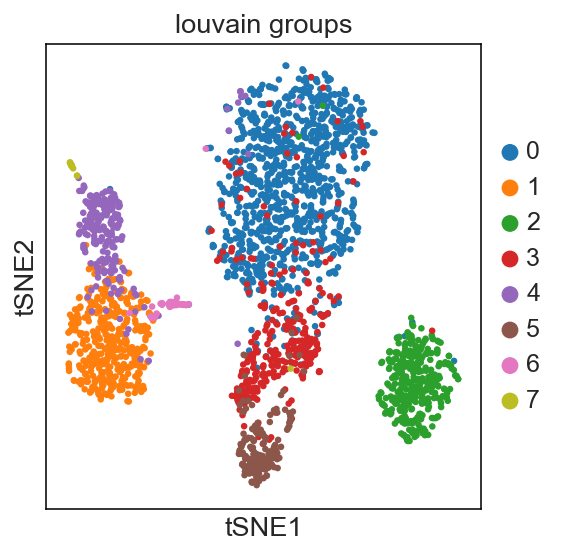

In [18]:
ax = sc.pl.tsne(adata_corrected, color='louvain_groups')

Save this, in case we need it later.

In [19]:
sc.write('pbmc3k_corrected', adata_corrected)

writing ./write/pbmc3k_corrected.h5


### Find marker genes

Let us compute a ranking for the highly differential genes in each cluster. This is a very simple method and but agrees quite well with the more advanced tests of Seurat.

For this, we should always use the logarithmized raw data.

reading file ./write/pbmc3k_corrected.h5
reading file ./write/pbmc3k_filtered_raw_log.h5
find differentially expressed genes
... consider "louvain_groups": ['0' '1' '2' '3' '4' '5' '6' '7'] with sample numbers [1110  417  340  328  219  166   42   16]
    finished (0:00:00.840) and added
    "rank_genes_groups_gene_names", np.recarray to be indexed by the `groups` (adata.add)
    "rank_genes_groups_gene_zscores", the scores (adata.add)
    "rank_genes_...", distributions of top-ranked genes (adata.smp)


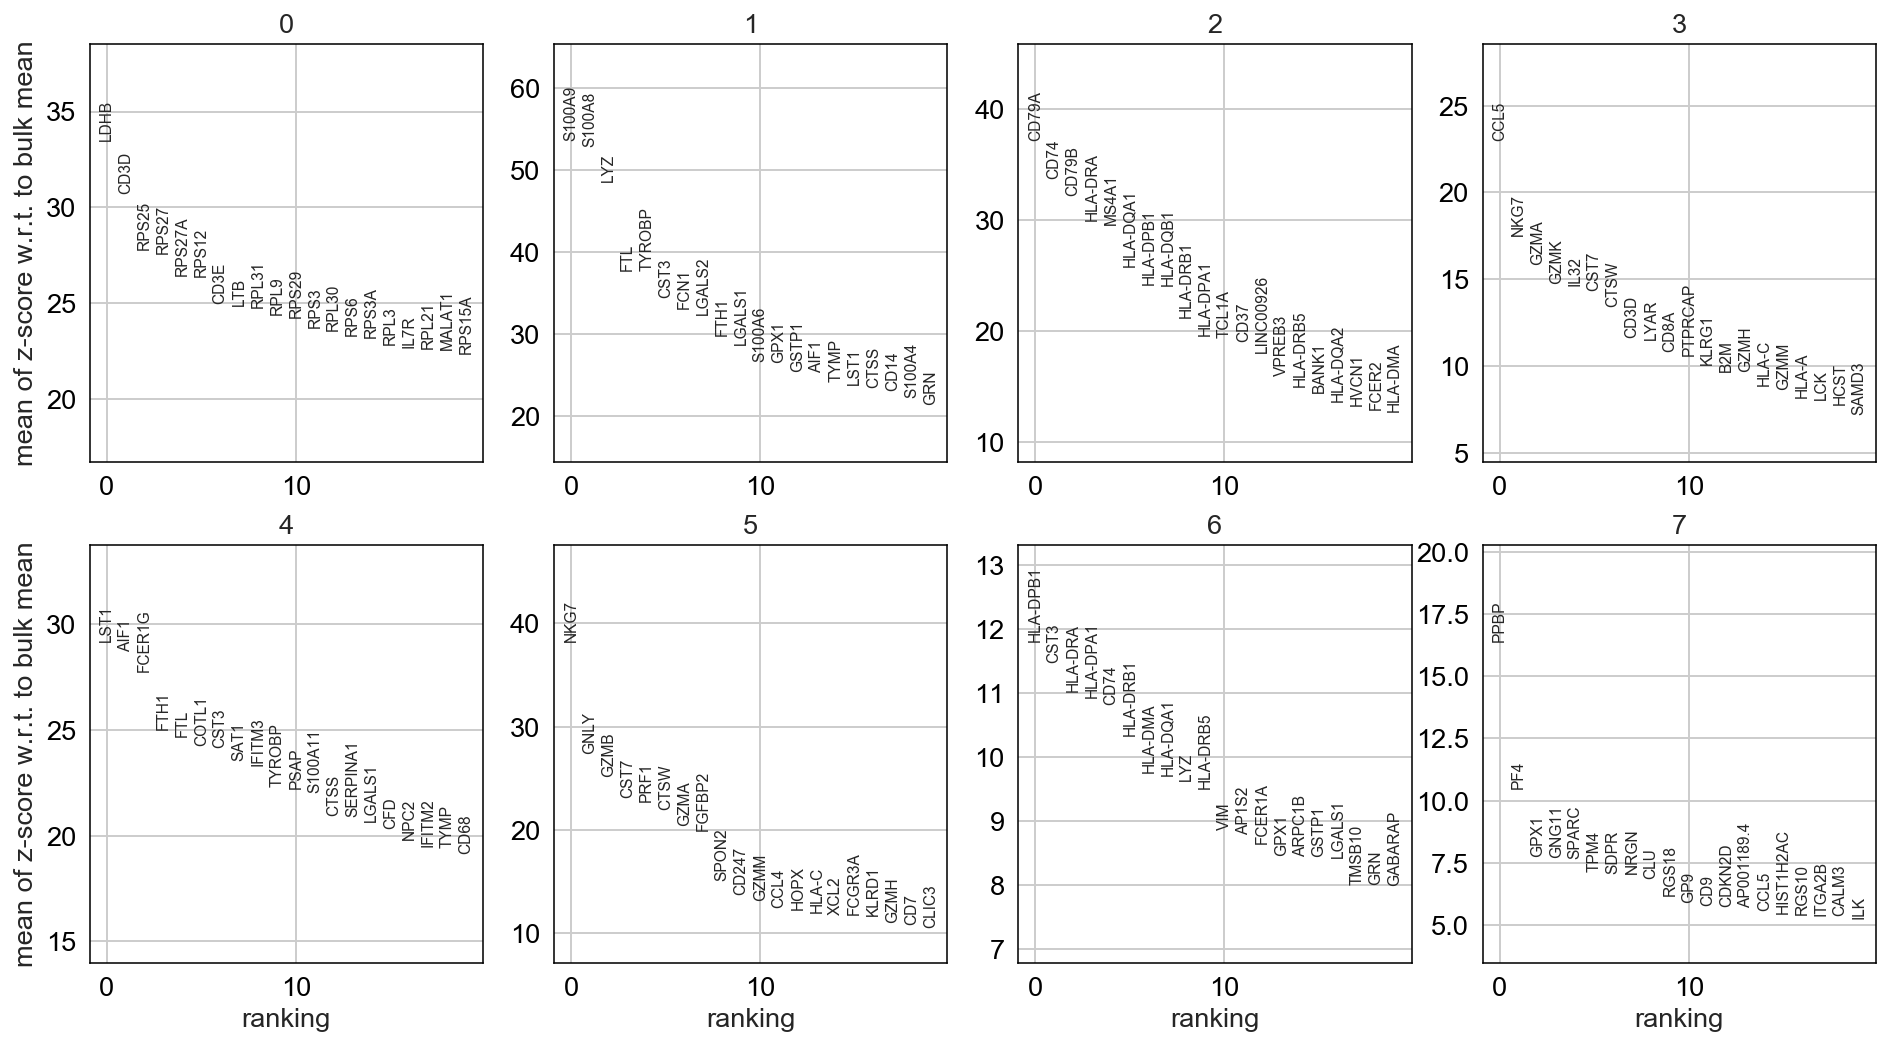

In [20]:
adata_corrected = sc.read('pbmc3k_corrected')
adata_raw = sc.read('pbmc3k_filtered_raw_log')
adata_raw.smp['louvain_groups'] = adata_corrected.smp['louvain_groups']
sc.tl.rank_genes_groups(adata_raw, 'louvain_groups')
sc.pl.rank_genes_groups(adata_raw, n_genes=20)

Even though the ranking by z-scores is a very simple procedure, the resulting genes agree very well with the marker genes fround by Seurat. With the exception of the marker genes of group 4, all marker genes mentioned in the [Seurat Tutorial](http://satijalab.org/seurat/pbmc-tutorial.html) can be found the rankings, and one can hence identify the cell types.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 |	CD8A |	CD8 T cells
4 |	FCGR3A, MS4A7 |	FCGR3A+ Monocytes
5 |	GNLY, NKG7 | 	NK cells
6 |	FCER1A, CST3 |	Dendritic Cells
7 |	PPBP |	Megakaryocytes

Save the result.

In [21]:
sc.write('pbmc3k_filtered_raw_log', adata_raw)
sc.write('pbmc3k_filtered_raw_log', adata_raw, ext='csv')

writing ./write/pbmc3k_filtered_raw_log.h5
writing csv files to ./write/pbmc3k_filtered_raw_log/


If you want to compare a certain gene across groups, use the following.

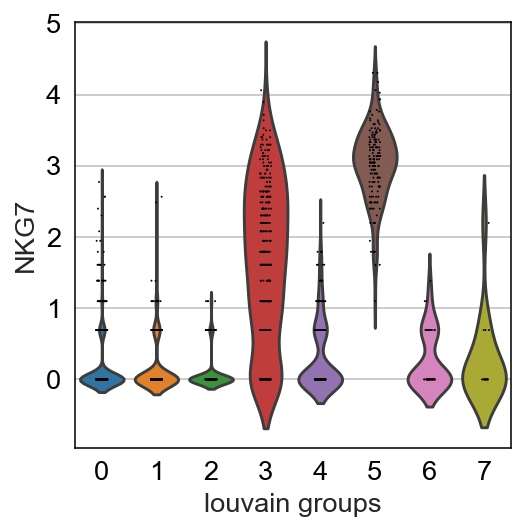

In [22]:
ax = sc.pl.violin(adata_raw, 'NKG7', group_by='louvain_groups')

If we want a more detailed view for a certain group, use the following function, you need to pass `compute_distribution=True` for this.

find differentially expressed genes
... consider "louvain_groups": ['0' '1' '2' '3' '4' '5' '6' '7'] with sample numbers [1110  417  340  328  219  166   42   16]
    finished (0:00:20.481) and added
    "rank_genes_groups_gene_names", np.recarray to be indexed by the `groups` (adata.add)
    "rank_genes_groups_gene_zscores", the scores (adata.add)
    "rank_genes_...", distributions of top-ranked genes (adata.smp)


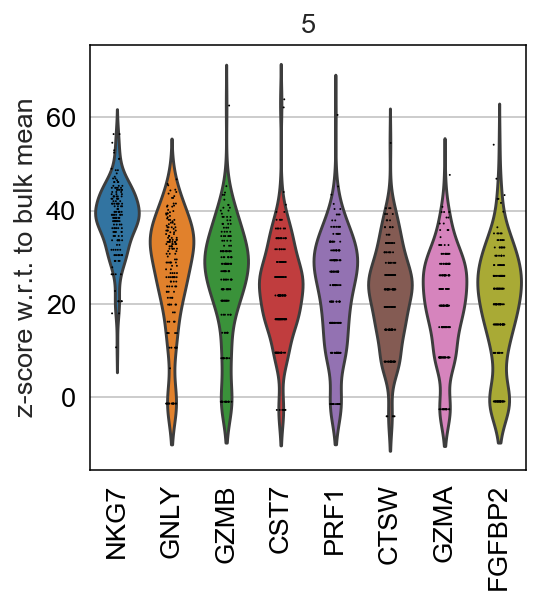

In [23]:
sc.tl.rank_genes_groups(adata_raw, 'louvain_groups', compute_distribution=True)
ax = sc.pl.rank_genes_groups_violin(adata_raw, groups='5', n_genes=8)

Actually mark the cell types.

In [24]:
adata_corrected.add['louvain_groups_names'] = [
    "CD4 T cells", "CD14+ Monocytes", 
    "B cells", "CD8 T cells", 
    "FCGR3A+ Monocytes", "NK cells", "Dendritic cells", 
    "Megakaryocytes"]
sc.write('pbmc3k_corrected', adata_corrected)

writing ./write/pbmc3k_corrected.h5


reading file ./write/pbmc3k_corrected.h5


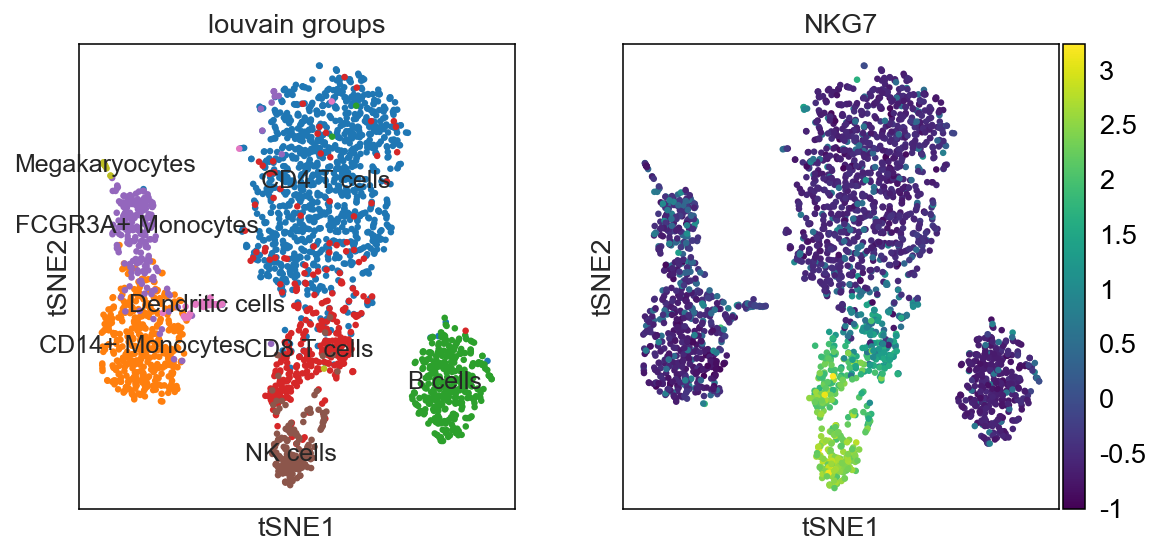

In [25]:
adata_corrected = sc.read('pbmc3k_corrected')
axs = sc.pl.tsne(adata_corrected, 
                 color=['louvain_groups', 'NKG7'],
                 legend_loc='on data')

If you want to export to "csv", simply provide the file extension.

In [26]:
sc.write('./write/pbmc3k_corrected.csv', adata_corrected)
# sc.write('pbmc3k_corrected', adata_corrected, ext='csv')  # is equivalent to previous line

writing csv files to ./write/pbmc3k_corrected/
